# Reranking/Retrieval with RoBERTa

This notebook contains two approaches on how to fine-tune RoBERTa for neural re-ranking. In the "Training" section the models are trained with huggingface Trainer. 

The following section contains code to train the same with pytorch lightning. This code is experimental. It wraps the training in pytorch lightning module. This enables us to evaluate with MAP during training and to increase the rate of difficult samples during training with the function described in the report. 

Due to limited time we could not finally finish this implementation. Therefore we trained with huggingface trainer and evaluated the models at checkpoints after 250 training steps with MAP. The evaluation for this is implemented in Bert_Reranking_EVAL.ipynb

## Imports

In [ ]:
!pip install pytorch-lightning
!pip install transformers datasets pickle5

In [ ]:
from google.colab import drive
import pickle5 as pickle
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import IterableDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import datetime
import os
import numpy as np
import time
from datasets import load_dataset, Dataset, concatenate_datasets
from collections import Counter
import matplotlib.pyplot as plt
from torch.nn import functional as F
from IPython import display
import gc
import random
import math
from torchmetrics import RetrievalMAP

## Load Files

In [ ]:
def save_as_pickle(obj, filename):
    """
    save an object in a pickle file dump
    :param obj: object to dump
    :param filename: target file
    :return:
    """
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(filename, 'wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)


def load_pickle(filename):
    """
    load an object from a given pickle file
    :param filename: source file
    :return: loaded object
    """
    with open(filename, 'rb') as file:
        return pickle.load(file)

In [ ]:
drive.mount('/content/drive', force_remount=True)  # use force_remount=True param after upload of new data

# file and folder names
ir_project_drive_folder = "Master/2 - FSS 2021/Information Retrieval/IR Projekt"
# ir_project_drive_folder = "IR Projekt"
full_ir_project_drive_folder = "/content/drive/My Drive/{}/".format(ir_project_drive_folder)

# datasets
nr_datasets_folder = full_ir_project_drive_folder + '/data/wikipedia/neural-retrieval-datasets'
nr_train_relevant_set_filename = nr_datasets_folder + '/train_relevant'
nr_train_irrelevant_random_set_filename = nr_datasets_folder + '/train_irrelevant_random'
nr_train_irrelevant_hard_random_set_filename = nr_datasets_folder + '/train_irrelevant_hard_random'
nr_train_irrelevant_hard_max_set_filename = nr_datasets_folder + '/train_irrelevant_hard_max'

# TODO: rework
nr_dev_relevant_set_filename = nr_datasets_folder + '/dev_relevant'
nr_dev_irrelevant_set_filename = nr_datasets_folder + '/dev_irrelevant'
nr_dev_irrelevant_smart_set_filename = nr_datasets_folder + '/dev_irrelevant_smart'
bm25_retrieved_dev_pl_map_filename = nr_datasets_folder + "/dev_pl_map.pkl"


# saved models
nr_models_folder = full_ir_project_drive_folder + 'saved_models/neural_retrieval'

# first cycle (random irrelevant)
model_path_roberta_first_10000_10000_wd_2e = nr_models_folder + '/roberta_first_10000_10000_wd_2e'
model_path_roberta_first_5000_15000_wd_2e = nr_models_folder + '/roberta_first_5000_15000_wd_2e'
model_path_roberta_first_720_19280_wd_2e = nr_models_folder + '/roberta_first_720_19280_wd_2e'

# second cycle (varying irrelevants)
model_path_roberta_second_5000_15000_wd_2e = nr_models_folder + '/roberta_second_5000_15000_wd_2e'
model_path_roberta_second_randhard_5000_15000_wd_2e = nr_models_folder + '/roberta_second_randhard_5000_15000_wd_2e'
model_path_roberta_second_maxhard_5000_15000_wd_2e = nr_models_folder + '/roberta_second_maxhard_5000_15000_wd_2e'

## Load Data

In [ ]:
train_dataset_relevant = Dataset.load_from_disk(nr_train_relevant_set_filename)
#train_dataset_relevant = train_dataset_relevant.remove_columns("type")
print("Train relevant:", train_dataset_relevant)

# dev_dataset_relevant = Dataset.load_from_disk(nr_dev_relevant_set_filename)
# print("Dev relevant:", dev_dataset_relevant)

Train relevant: Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'question', 'relevant_document', 'type'],
    num_rows: 110516
})


In [ ]:
# train_dataset_irrelevant_random = Dataset.load_from_disk(nr_train_irrelevant_random_set_filename)
# print("Train irrelevant random:", train_dataset_irrelevant_random)

#dev_dataset_irrelevant_hard = Dataset.load_from_disk(nr_dev_irrelevant_smart_set_filename)
#print("Dev irrelevant smart:", dev_dataset_irrelevant_hard)

Train irrelevant random: Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'question', 'relevant_document', 'type'],
    num_rows: 110647
})


In [ ]:
# train_dataset_irrelevant_hard_random = Dataset.load_from_disk(nr_train_irrelevant_hard_random_set_filename)
# print("Train irrelevant hard random:", train_dataset_irrelevant_hard_random)

In [ ]:
train_dataset_irrelevant_hard_max = Dataset.load_from_disk(nr_train_irrelevant_hard_max_set_filename)
print("Train irrelevant hard max:", train_dataset_irrelevant_hard_max)

Train irrelevant hard max: Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'question', 'relevant_document', 'type'],
    num_rows: 123772
})


In [ ]:
def merge_datasets(relevant_dataset, irrelevant_dataset, number_relevants=None, number_irrelevants=None, shuffling=True):
  """ 
  merges two datasets
  number_relevants: number of rows from first set to take
  number_irrelevants: number of rows from second set to take
  shuffling: flag if datasets should be shuffled before drawing samples
  """
  # shuffle initial dataset
  if shuffling:
    relevant_dataset = relevant_dataset.shuffle(seed=40)
    irrelevant_dataset = irrelevant_dataset.shuffle(seed=40)

  # limit rows
  if number_relevants:
    relevant_dataset = Dataset.from_dict(relevant_dataset[:number_relevants])
  if number_irrelevants:
    irrelevant_dataset = Dataset.from_dict(irrelevant_dataset[:number_irrelevants])
  
  # concat limited sets and shuffle again
  concatted = concatenate_datasets([relevant_dataset, irrelevant_dataset])
  if shuffling:
    concatted = concatted.shuffle(seed=40)

  return concatted

In [ ]:
train_dataset = merge_datasets(train_dataset_relevant, train_dataset_irrelevant_hard_max, number_relevants=5000, number_irrelevants=15000)
print(train_dataset)
#dev_dataset = merge_datasets(dev_dataset_relevant, dev_dataset_irrelevant, number_relevants=10000, number_irrelevants=10000)
#print(dev_dataset)

Loading cached shuffled indices for dataset at /content/drive/My Drive/Master/2 - FSS 2021/Information Retrieval/IR Projekt/data/wikipedia/neural-retrieval-datasets/train_relevant/cache-f442c7fd50de0853.arrow
Loading cached shuffled indices for dataset at /content/drive/My Drive/Master/2 - FSS 2021/Information Retrieval/IR Projekt/data/wikipedia/neural-retrieval-datasets/train_irrelevant_hard_max/cache-50f0e46b5001a7f0.arrow


Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'question', 'relevant_document', 'type'],
    num_rows: 20000
})


## Training

In [ ]:
# model = RobertaForSequenceClassification.from_pretrained('roberta-base') 
model = RobertaForSequenceClassification.from_pretrained(model_path_roberta_first_5000_15000_wd_2e + '/checkpoint-5000') 

In [ ]:
class RetrievalTrainer(Trainer):

  def __init__(self, model_name, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.loss_graph_file = kwargs['args'].output_dir + '/loss_graph.png'
    self.logs_file = kwargs['args'].output_dir + '/training_logs.pkl'
    self.training_loss_graph_file = kwargs['args'].output_dir + '/training_loss_graph.png'
    self.model_name = model_name

    self.current_training_loss = None
    self.losses = []
    self.training_losses = []
    self.training_logs = []

  def log(self, logs):
    super().log(logs)
    if 'loss' in logs:
      self.training_logs.append(logs)
      self.current_training_loss = logs['loss']
      self.training_losses.append(logs['loss'])
      if logs['epoch'] % 0.1 == 0:
        save_as_pickle(self.training_logs, self.logs_file)
    elif 'eval_loss' in logs and self.current_training_loss:
      self.losses.append((logs['epoch'], self.current_training_loss, logs['eval_loss']))
    display.clear_output(wait=True)
    # self.plot_losses()
    self.plot_training_losses(save=False)

  def plot_losses(self, save=True, show=True):
    epochs = [loss_log[0] for loss_log in self.losses]
    training_losses = [loss_log[1] for loss_log in self.losses]
    eval_losses = [loss_log[2] for loss_log in self.losses]
    plt.plot(epochs, training_losses, color='cornflowerblue',  label='Training Loss') 
    plt.plot(epochs, eval_losses, color='coral', label='Evaluation Loss') 
    plt.title(self.model_name)
    plt.legend(loc='upper right')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if save:
      plt.savefig(self.loss_graph_file)
    if show:
      plt.show()

  def plot_training_losses(self, save=True, show=True):
    steps = [idx for idx, training_loss in enumerate(self.training_losses)]
    training_losses = [training_loss for training_loss in self.training_losses]
    plt.plot(steps, training_losses, color='cornflowerblue',  label='Training Loss') 
    plt.title(self.model_name)
    plt.legend(loc='upper right')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    if save:
      plt.savefig(self.training_loss_graph_file)
    if show:
      plt.show()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = model_path_roberta_second_maxhard_5000_15000_wd_2e,# output directory
    logging_dir = model_path_roberta_second_maxhard_5000_15000_wd_2e + '/logs',            # directory for storing logs
    num_train_epochs = 2,              # total number of training epochs
    per_device_train_batch_size = 8,  # batch size per device during training
    per_device_eval_batch_size = 8,   # batch size for evaluation
    weight_decay = 0.01,               # strength of weight decay
    learning_rate = 5e-6,
    logging_steps = 10,
    save_steps = 250,
)

trainer = RetrievalTrainer(
    "RoBERTa 5000 15000, Second Cycle, Max Hard",
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

In [ ]:
gc.collect()
torch.cuda.empty_cache()
trainer.train()

In [ ]:
model.save_pretrained(model_path_roberta_second_maxhard_5000_15000_wd_2e)
save_as_pickle(trainer.training_logs, model_path_roberta_second_maxhard_5000_15000_wd_2e + '/training_logs.pkl')

## Experimental Training: Pytorch Lightning

### Data Module

In [ ]:
class RetrievalDataModule(pl.LightningDataModule):

  def __init__(self, train_relevant_dataset, train_irrelevant_dataset, train_irrelevant_hard_dataset,
                      dev_dataset, number_relevant=5000, number_irrelevant=5000, hard_factor_train=2.5):
    super().__init__()
    self.train_set = DynamicDataset(train_relevant_dataset, train_irrelevant_dataset, train_irrelevant_hard_dataset, number_relevant, number_irrelevant, hard_factor_train)
    self.dev_set = dev_dataset
  
  def prepare_data(self):
    """ download data """
    pass

  def setup(self, stage: str = None):
    """ set data based on phase """
    pass

  def train_dataloader(self):
    print("train data loader called")
    return DataLoader(self.train_set, batch_size=8)

  def val_dataloader(self):
    print("train data loader called")
    return DataLoader(self.dev_set, batch_size=8)

  def test_dataloader(self):
    pass


class DynamicDataset(torch.utils.data.Dataset):

    def __init__(self, relevant_dataset, irrelevant_dataset, irrelevant_hard_dataset, 
                  relevant_size, irrelevant_size, hard_factor=2.5):
      super().__init__()
      self.relevant_dataset = relevant_dataset
      self.irrelevant_dataset = irrelevant_dataset
      self.irrelevant_hard_dataset = irrelevant_hard_dataset
      
      self.whole_size = relevant_size + irrelevant_size
      self.relevant_size = relevant_size
      self.irrelevant_size = irrelevant_size

      self.num_relevant = 0
      self.num_irrelevant = 0
      self.num_irrelevant_hard = 0
      
      self.hard_factor = hard_factor
      self.hard_probabilities = []

    def log_train_set_distribution(self):
      print(f' Train set {self.whole_size} '.center(40, '-'))
      print('Relevant samples:', self.num_relevant)
      print('Irrelevant samples:', self.num_irrelevant)
      print('Irrelevant samples hard:', self.num_irrelevant_hard)

    def __getitem__(self, idx):
      hard_probability = idx**self.hard_factor / self.__len__()**self.hard_factor
      self.hard_probabilities.append(hard_probability)

      r = random.uniform(0, 1)
      relevant_threshold_upper = self.relevant_size / self.whole_size

      irrelevant_hard_threshold_lower = 1 - hard_probability

      irrelevant_threshold_lower = relevant_threshold_upper
      irrelevant_threshold_upper = irrelevant_hard_threshold_lower

      if r < relevant_threshold_upper:
        r_int = random.randint(0, len(self.relevant_dataset) - 1)
        item = self.relevant_dataset.__getitem__(r_int)
        self.num_relevant += 1
      
      elif r > irrelevant_threshold_lower and r < irrelevant_threshold_upper:
        r_int = random.randint(0, len(self.irrelevant_dataset) - 1)
        item = self.irrelevant_dataset.__getitem__(r_int)
        self.num_irrelevant += 1

      elif r > irrelevant_hard_threshold_lower:
        r_int = random.randint(0, len(self.irrelevant_hard_dataset) - 1)
        item = self.irrelevant_hard_dataset.__getitem__(r_int)
        self.num_irrelevant_hard += 1
      
      if 'type' in item:
        item.pop('type')
      
      return item

    def __len__(self):
      return int(self.whole_size)

    def plot_hard_probabilities(self):
      indexes = [i for i in range(len(self.hard_probabilities))]
      hard_probabilities = [p for p in self.hard_probabilities]
      plt.plot(indexes, hard_probabilities, color='cornflowerblue') 
      plt.title("Share of hard samples in irrelevant samples")
      plt.xlabel("Training Set Size")
      plt.ylabel("Share")

In [ ]:
dm = RetrievalDataModule(train_dataset_relevant, train_dataset_irrelevant, train_dataset_irrelevant_hard, 
                         dev_dataset, number_relevant=100, number_irrelevant=100, hard_factor_train=10)
for idx, batch in enumerate(dm.train_dataloader()):
  pass
  # print(batch['label'])

train data loader called


------------ Train set 200 -------------
Relevant samples: 94
Irrelevant samples: 89
Irrelevant samples hard: 17


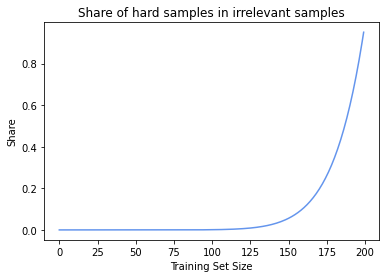

In [ ]:
dm.train_set.log_train_set_distribution()
dm.train_set.plot_hard_probabilities()

### Module

In [ ]:
class MapDataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
      self.encodings = encodings

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      return item

  def __len__(self):
      return len(self.encodings['input_ids'])

In [ ]:
class RetrievalModule(pl.LightningModule):

  def __init__(self, model, model_desc, model_folder, data_module, map_encodings, lr=5e-5, wd=0.01):
    # learning rate and weight decay have same default values as in huggingface TrainerArguments
    super().__init__()
    self.model = model
    self.model_desc = model_desc
    self.data_module = data_module
    self.lr = lr
    self.wd = wd

    self.training_losses = []
    self.loss_pairs = []  # (train_loss, val_loss)
    # list of losses of different batches from one validation
    self.current_val_batch_losses = []

    if not os.path.exists(model_folder):
      os.makedirs(model_folder)
    self.training_loss_graph_file = model_folder + '/traing_loss.png'
    self.loss_graph_file = model_folder + '/graph.png'

    # map dataset attributes
    self.map_indexes, self.map_targets, self.map_encodings = map_encodings
    self.huggingface_trainer = Trainer(model=model,args=TrainingArguments(output_dir=model_folder))#,disable_tqdm=False

  def training_step(self, batch, batch_idx):
    """
    compute training loss for given batch
    """
    batch = self.transform_batch_for_bert(batch)
    outputs = self.model(**batch)
    loss = outputs[0]
    self.training_losses.append(loss.item())
    if batch_idx % 10 == 0:
      display.clear_output(wait=True)
      self.plot_training_losses()
      self.plot_losses()
      print("T Batch {} {} | train_loss avg: {} | train_loss: {}".format(batch_idx, datetime.datetime.now(), np.mean(self.training_losses), loss))
    return loss

  def validation_step(self, batch, batch_idx, dataloader_idx=0):
    """
    perform a validation for a given batch
    """
    if batch_idx % 1 == 0 and self.loss_pairs:
      print("V Batch", batch_idx, datetime.datetime.now(), 
            'val_loss avg:', np.mean([loss_pair[1] for loss_pair in self.loss_pairs]))

    batch = self.transform_batch_for_bert(batch)
    outputs = self.model(**batch)
    loss, logits = outputs[:2]
    preds = torch.argmax(logits, axis=1)
    labels = batch["labels"]

    # save loss current batch in list to average it over all batches in one validation round
    self.current_val_batch_losses.append(loss.item())

    return {'loss': loss, "preds": preds, "labels": labels}

  def on_validation_end(self):
    """ 
    print avg training and evaluation loss until now
    compute MAP
    plot loss graphs
    """
    display.clear_output(wait=True)
    # break if training_losses are empty -> case for sanity check
    if not self.training_losses:
      return
    current_val_loss = np.mean(self.current_val_batch_losses)
    self.loss_pairs.append((self.training_losses[-1], 
                            current_val_loss,
                            self.compute_map()))
    # clear batch validation losses for next validation
    self.current_val_batch_losses.clear()

    
    if self.loss_pairs:
      self.plot_losses()
    if self.training_losses:
      self.plot_training_losses()

    if self.training_losses:
      train_loss_mean = np.mean(self.training_losses)
      print('train_loss mean', train_loss_mean)
    if self.loss_pairs:
      val_loss_mean = np.mean([loss_pair[1] for loss_pair in self.loss_pairs])
      print('val_loss mean', val_loss_mean)
      print('last val_loss', current_val_loss)
    self.data_module.train_set.log_train_set_distribution()
    self.data_module.train_set.plot_hard_probabilities()

  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.wd)

  @staticmethod
  def transform_batch_for_bert(batch):
    """
    rename labels and transform input_ids to a to two dim tensor
    transpose dimensions: (512, batch_size) -> (batch_size, 512)
    """
    # remove unnecessary fields
    if 'type' in batch:
      batch.pop('type')
    batch.pop('question')
    batch.pop('relevant_document')

    # transform necessary fields
    batch['labels'] = batch.pop('label')
    batch['input_ids'] = torch.stack(batch.pop('input_ids')).transpose(0, 1)
    batch['attention_mask'] = torch.stack(batch.pop('attention_mask')).transpose(0, 1)

    return batch

  def plot_losses(self, save=True, show=True):
    val_steps = [i for i in range(len(self.loss_pairs))]
    training_losses = [loss_pair[0] for loss_pair in self.loss_pairs]
    eval_losses = [loss_pair[1] for loss_pair in self.loss_pairs]
    maps = [loss_pair[2] for loss_pair in self.loss_pairs]
    plt.plot(val_steps, training_losses, linestyle='solid', color='cornflowerblue',  label='Training Loss') 
    plt.plot(val_steps, eval_losses, linestyle='dotted', color='coral', label='Evaluation Loss')
    plt.plot(val_steps, maps, linestyle='dashed', color='yellowgreen', label='MAP') 
    plt.title(self.model_desc)
    plt.legend(loc='upper right')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if save:
      plt.savefig(self.loss_graph_file)
    if show:
      plt.show()

  def plot_training_losses(self, save=True, show=True):
    batches = [i for i in range(len(self.training_losses))]
    training_losses = [loss for loss in self.training_losses]
    plt.plot(batches, training_losses, color='cornflowerblue',  label='Training Loss') 
    plt.title(self.model_desc)
    plt.legend(loc='upper right')
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    if save:
      plt.savefig(self.training_loss_graph_file)
    if show:
      plt.show()

  def compute_map(self):
    retrieval_map = RetrievalMAP()
    prediction_output = self.huggingface_trainer.predict(MapDataset(self.map_encodings))
    display.clear_output(wait=True)
    predictions = prediction_output.predictions
    preds = torch.tensor(predictions)
    res = F.softmax(preds, dim = 1)
    res = res[:,1]
    map = retrieval_map(res, self.map_targets, indexes=self.map_indexes).item()
    return map

In [ ]:
map_encodings = load_pickle(bm25_retrieved_dev_pl_map_filename)

In [ ]:
# del model
model = RobertaForSequenceClassification.from_pretrained('roberta-base') 

In [ ]:
data_module = RetrievalDataModule(train_dataset_relevant, train_dataset_irrelevant, train_dataset_irrelevant_hard,
                                   dev_dataset, number_relevant=5000, number_irrelevant=5000, hard_factor_train=2.5)
retrieval_module = RetrievalModule(model, 
                                   'RoBERTa 5000 5000, 2E, UEV, Incr. Hard (2.5)',
                                   model_path_roberta_pl_smart_5000_5000_wd_2e_25,
                                   data_module,
                                   map_encodings,
                                   lr=5e-5, wd=0.01)

### Training

In [ ]:
gc.collect()
torch.cuda.empty_cache()

checkpoint_callback = ModelCheckpoint(
    dirpath=model_path_roberta_pl_smart_5000_5000_wd_2e_25,
    filename='Checkpoint-{step}',
    every_n_train_steps=500
)

trainer = pl.Trainer(
    max_epochs=2,
    gpus=1,
    val_check_interval=0.25,  # checks 4 times per epoch
    callbacks=[checkpoint_callback],
    num_sanity_val_steps=0)

# start timer
start = datetime.datetime.now()
print('Start:', start)

trainer.fit(retrieval_module, data_module)

# end timer and compute elapsed time
end = datetime.datetime.now()
print('End:', end)
elapsed_time = end - start
seconds = elapsed_time.total_seconds()
print('Elapsed Minutes: {}'.format(seconds / 60))
print('Elapsed Hours: {}'.format(seconds / 3600))